# **Load, analyse and visualise dataset**

In [31]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
from PIL import Image
import random
import os

In [32]:
# Define Base Path 
base_path = "C:/Users/funmi/GitRepositories/Road-Sign-Detection"

# Define Folder Paths
training_folder = os.path.join(base_path, 'traffic_Data/TRAIN')
val_folder = os.path.join(base_path, 'traffic_Data/VAL')
test_folder = os.path.join(base_path, 'traffic_Data/TEST')
labels_path = os.path.join(base_path, 'labels.csv')

# Load Labels CSV 
labels_df = pd.read_csv(labels_path)

# Basic Checks on labels.csv (e.g., missing values, duplicates)
print("Missing values in labels.csv:")  # Missing class names or IDs
print(labels_df.isnull().sum())

print("\nDuplicate entries in labels.csv:")
print(labels_df.duplicated().sum())

print("\nPreview of labels.csv:") 
print(labels_df.head())

# Class Information 
class_names = sorted(labels_df['ClassId'].unique())
num_classes = len(class_names)
print(f"\nTotal number of classes: {num_classes}")

# Verify that Mapping: Class ID -> Class Name
class_id_to_name = dict(zip(labels_df['ClassId'], labels_df['Name']))
print("\nExample class mapping (first 5):")
print(dict(list(class_id_to_name.items())[:5]))

# Check Folder Existence 
print("\nTraining folder exists:", os.path.exists(training_folder))
print("Validation folder exists:", os.path.exists(val_folder))

# List Class Folders
if os.path.exists(training_folder):
    print("\nClasses in training folder:")
    print(os.listdir(training_folder))

if os.path.exists(val_folder):
    print("\nClasses in validation folder:")
    print(os.listdir(val_folder))


Missing values in labels.csv:
ClassId    0
Name       0
dtype: int64

Duplicate entries in labels.csv:
0

Preview of labels.csv:
   ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)

Total number of classes: 58

Example class mapping (first 5):
{0: 'Speed limit (5km/h)', 1: 'Speed limit (15km/h)', 2: 'Speed limit (30km/h)', 3: 'Speed limit (40km/h)', 4: 'Speed limit (50km/h)'}

Training folder exists: True
Validation folder exists: True

Classes in training folder:
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']

Classes in validation folder:
['0', '1', '10'

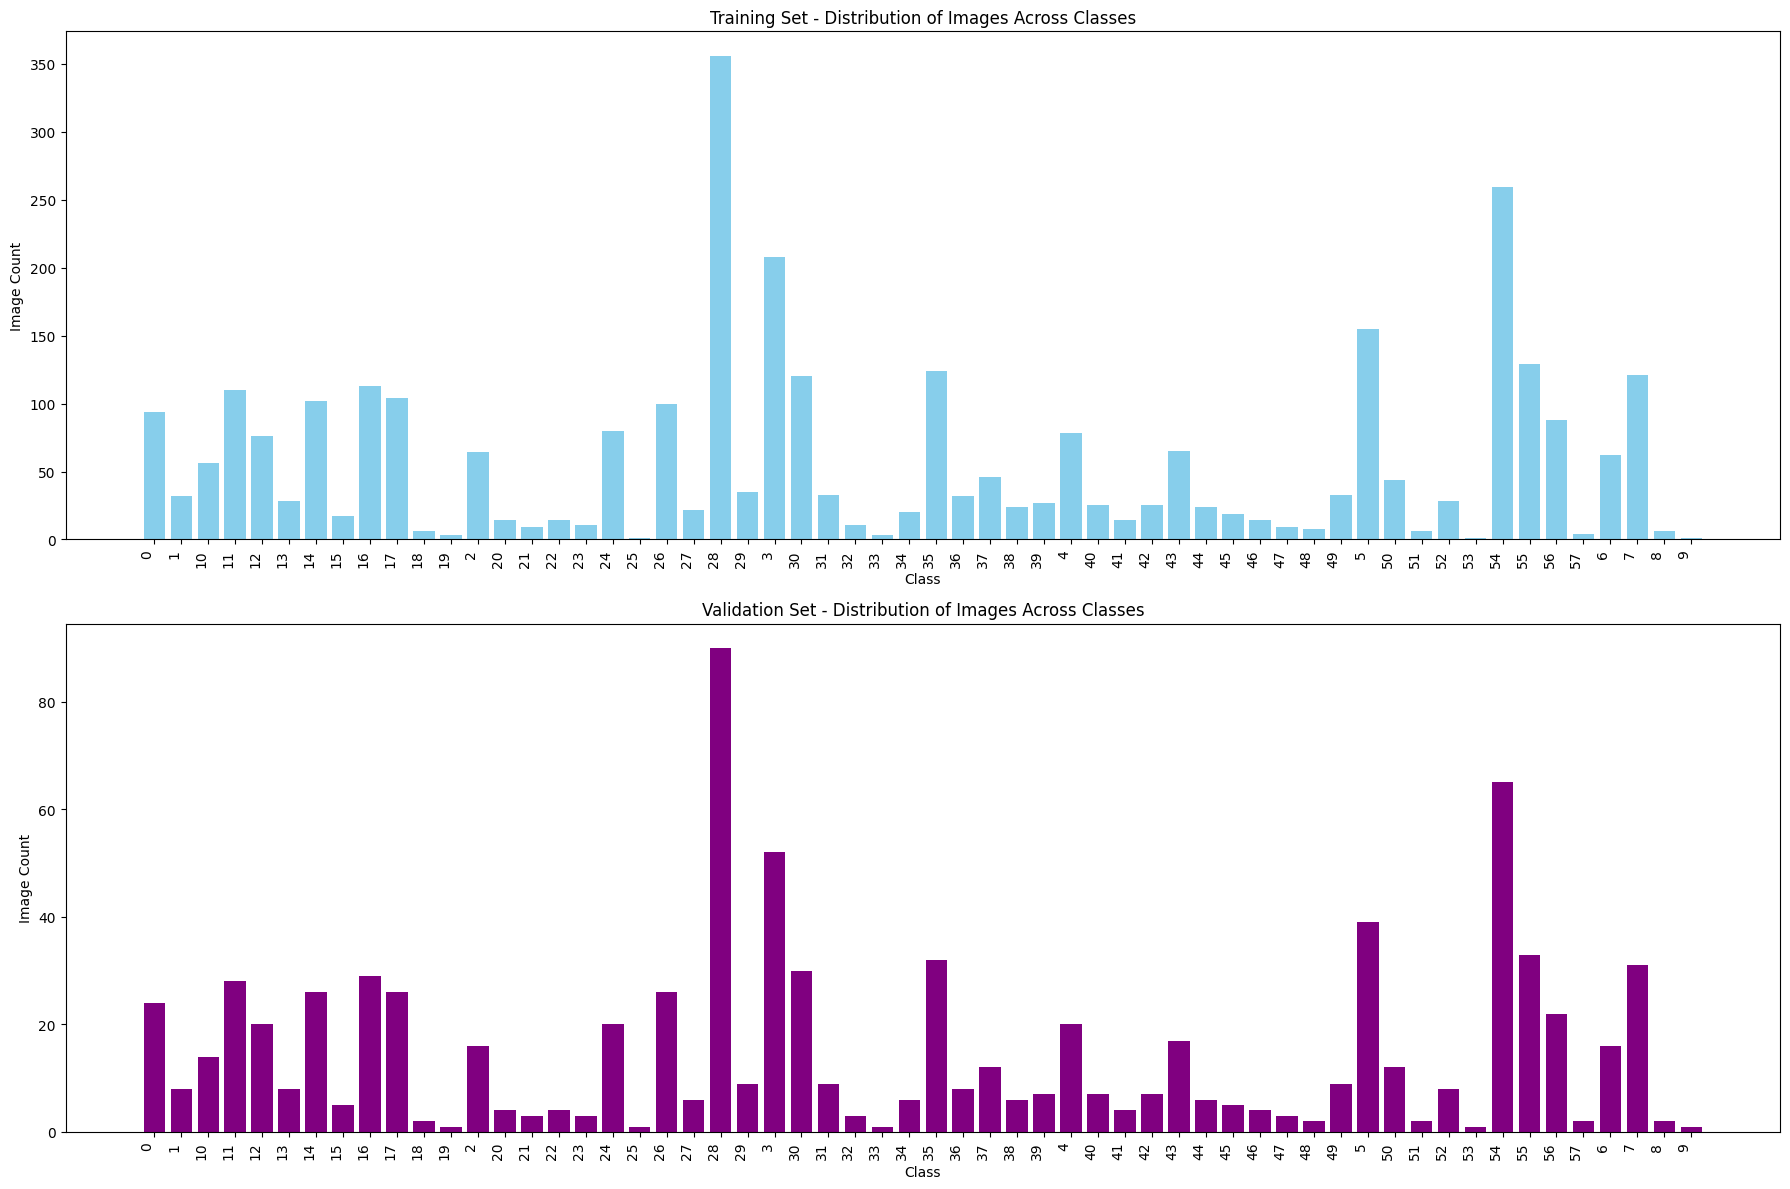

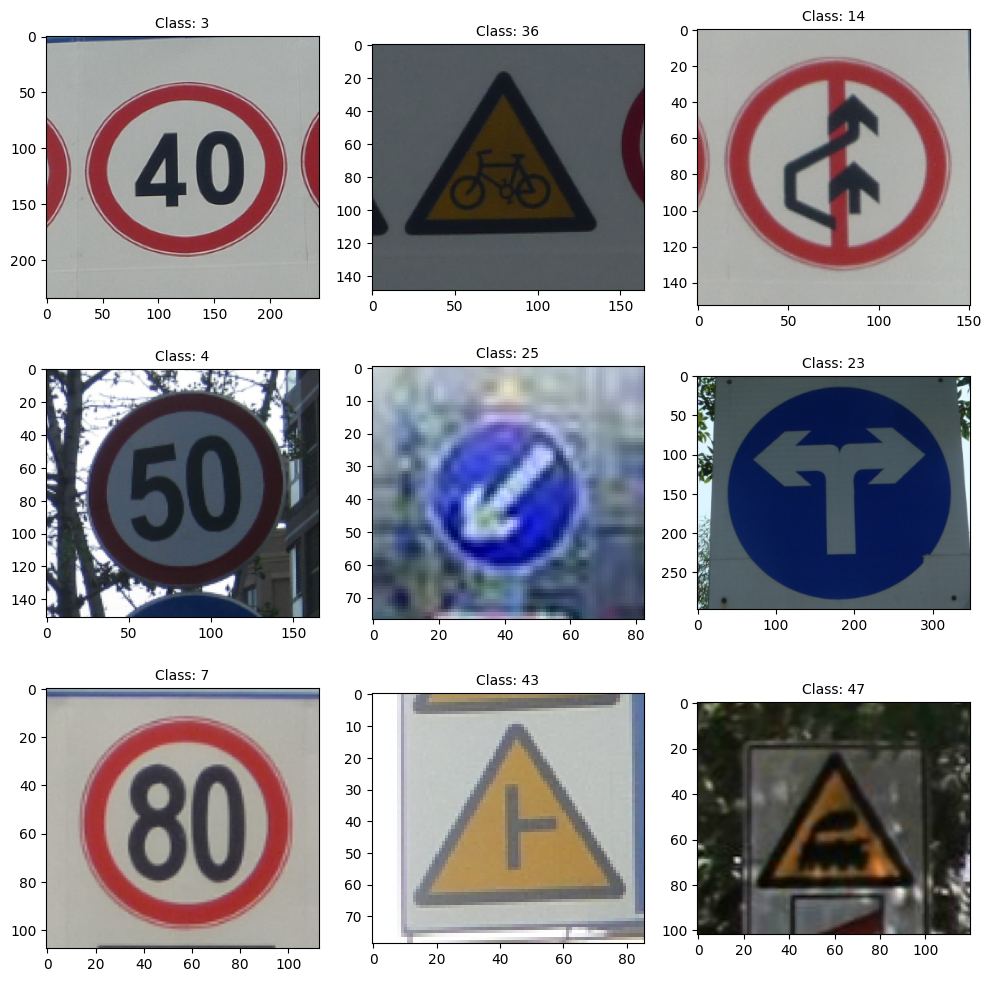

In [33]:
# Examine class distribution in training and validation folders

# Function to get class counts 
def get_class_counts(folder_path):
    class_names =[]
    class_counts = []
    for class_folder in os.listdir(folder_path):
        folder_subpath = os.path.join(folder_path, class_folder)
        if os.path.isdir(folder_subpath):
            class_names.append(class_folder)
            num_images = len(os.listdir(folder_subpath))
            class_counts.append(num_images)
    return class_names, class_counts

# Get folder counts for training and validation folders 
train_folder_names, train_folder_counts = get_class_counts(training_folder)
val_folder_names, val_folder_counts = get_class_counts(val_folder)

# Plot histogram for distribution of classes
plt.figure(figsize=(18,12))

plt.subplot(2 ,1 ,1)
plt.bar(train_folder_names, train_folder_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Training Set - Distribution of Images Across Classes')
plt.xticks(rotation=90, ha='right')

plt.subplot(2 ,1 ,2)
plt.bar(val_folder_names, val_folder_counts, color='purple')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Validation Set - Distribution of Images Across Classes')
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

# Plot random images to visualise the dataset
def plot_random_images(folder_path, num_images=9):
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        class_folder = random.choice(os.listdir(folder_path))
        image_path = os.path.join(folder_path, class_folder, random.choice(os.listdir(os.path.join(folder_path, class_folder))))
        image = Image.open(image_path)
        plt.subplot(3,3,i + 1)
        plt.imshow(image)
        plt.title(f'Class: {class_folder}', fontsize=10)
        plt.axis('on')
    plt.tight_layout()
    plt.show()

# Plot random images from training set
plot_random_images(training_folder)

In [34]:
# There is a class imbalance issue in the dataset.
# The model may be biased towards the classes with more images because it sees them more frequently during training.
# This can lead to poor performance on classes with fewer images, as the model may not learn to recognise them effectively.
# Eg. Class 28 has 350 images while Class 19 has only 3 images in the training set.

# To address this, we can oversample to boost the underrepresented classes.
# By duplicating images from the underrepresented classes or using data augmentation techniques to create variations.
# We can also use class weights to give more importance to the underrepresented classes during training.
# This way, the model will pay more attention to these classes and learn to recognise them better.


# **Preprocessing steps**

In [35]:
# Image dimensions and batch size
image_shape = (75,75)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,  # rescale pixel values to [0, 1] range (Must-have normalization step).
                            rotation_range=10, # rotate image by 10 degrees (Road signs can be slightly tilted).
                            width_shift_range=0.1, # shift images horizontally by 10% (Capturing misalignment).
                            height_shift_range=0.1, # shift images vertically by 10%
                            shear_range=0.1, # applies shear transformation
                            zoom_range=0.1,  # zoom image by 10% (Helps model generalize to closer/farther views).
                            horizontal_flip=False, # no need to flip road signs horizontally.
                            fill_mode='nearest', # fills in newly created pixels using nearest pixel value.
                            brightness_range=[0.8, 1.2], # adjust brightness (Road signs can be in different lighting conditions).
                            )
                            # Validation data should represent real-world inputs without distortions so no augmentation.
val_datagen = ImageDataGenerator(rescale = 1./255) # This ensures that the model receives validation data in the same scale as the training data.
test_datagen = ImageDataGenerator(rescale=1./255) # For test data, we only rescale the pixel values.

# Generators efficiently load, preprocess, and feed image data into the model in real-time, batch by batch.
# Generate training data
train_generator = train_datagen.flow_from_directory(
                            training_folder,
                            class_mode ='categorical',
                            batch_size = batch_size,
                            target_size = image_shape,
                            shuffle=True # Randomisation at each epoch(iteration) improves learning
                        )

# Generate validation data
validation_generator = val_datagen.flow_from_directory(
                            val_folder,
                            class_mode ='categorical',
                            batch_size = batch_size,
                            target_size = image_shape
                        )
# Generate test data
test_generator = test_datagen.flow_from_directory(
                            test_folder,
                            class_mode='categorical',
                            batch_size=batch_size,
                            target_size=image_shape,
                            shuffle=False  # keeps the original order of the data
)

Found 3313 images belonging to 58 classes.
Found 857 images belonging to 58 classes.
Found 0 images belonging to 0 classes.


#  **Visualise a batch of images from the generator**

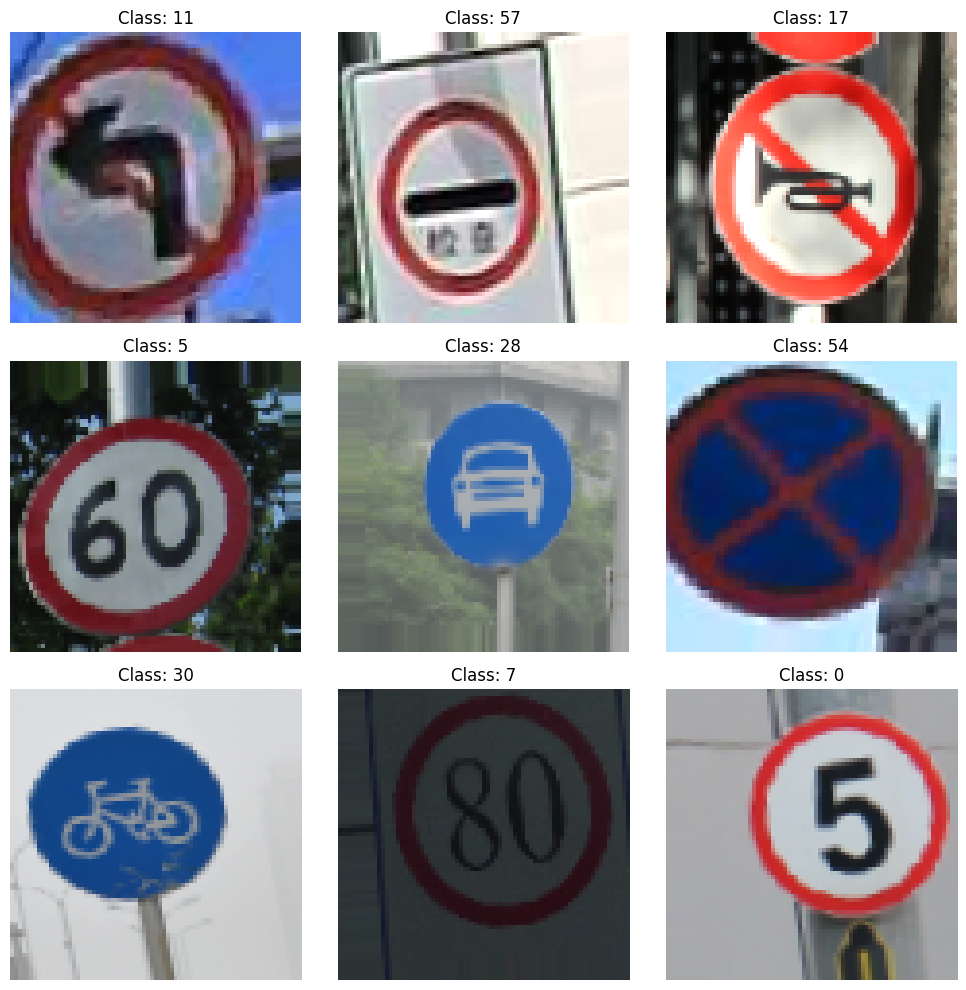

In [36]:
# Get a batch of images and labels
images, labels = next(train_generator)  # Fetch one batch

# Display the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])  # one-hot to class index
    class_name = list(train_generator.class_indices.keys())[class_index]
    plt.title(f'Class: {class_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [37]:
# Confirm the shape of the images and labels in the batch
print("Shape of images in the batch:", images.shape)  # (batch_size, height, width, channels)
print("Shape of labels in the batch:", labels.shape)  # (batch_size, num_classes)

Shape of images in the batch: (32, 75, 75, 3)
Shape of labels in the batch: (32, 58)


# **Build a custom model**

In [38]:
from tensorflow.keras import layers, models

input_shape = (75, 75, 3)

# Create the CNN model using the functional API
inputs = tf.keras.Input(shape=input_shape)
conv1 = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
maxpool1 = layers.MaxPooling2D((2, 2))(conv1)
conv2 = layers.Conv2D(128, (3, 3), activation='relu')(maxpool1)
maxpool2 = layers.MaxPooling2D((2, 2))(conv2)
flatten = layers.Flatten()(maxpool2)
dense1 = layers.Dense(256, activation='relu')(flatten)
dropout1 = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(128, activation='relu')(dropout1)
dropout2 = layers.Dropout(0.5)(dense2)
outputs = layers.Dense(58, activation='softmax')(dropout2)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model with an appropriate optimiser, loss function, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# Using callbacks to stop training if validation performance stops improving.

early_stopping = EarlyStopping(monitor='val_loss', # monitor validation loss
                               patience=5, # how many epochs to wait after last improvement
                               restore_best_weights=True) # restores model to best state

In [40]:
print(model.summary())
history = model.fit(
          train_generator,
          epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stopping]       
          )

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 73, 73, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,586,234 (36.57 MB)

 Trainable params: 9,586,234 (36.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


c:\Users\funmi\GitRepositories\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.0866 - loss: 3.9193 - val_accuracy: 0.2567 - val_loss: 2.8610
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 347ms/step - accuracy: 0.2456 - loss: 2.9490 - val_accuracy: 0.3769 - val_loss: 2.2676
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 304ms/step - accuracy: 0.3103 - loss: 2.4544 - val_accuracy: 0.4702 - val_loss: 1.9053
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - accuracy: 0.3880 - loss: 2.1341 - val_accuracy: 0.5403 - val_loss: 1.5401
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.4311 - loss: 1.9124 - val_accuracy: 0.6056 - val_loss: 1.2945
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.5086 - loss: 1.6276 - val_accuracy: 0.6546 - val_loss: 1.1251
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.5375 - loss: 1.4960 - val_accuracy: 0.7165 - val_loss: 0.9491
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 312ms/step - accuracy: 0.5721 - loss: 1.3760 - val

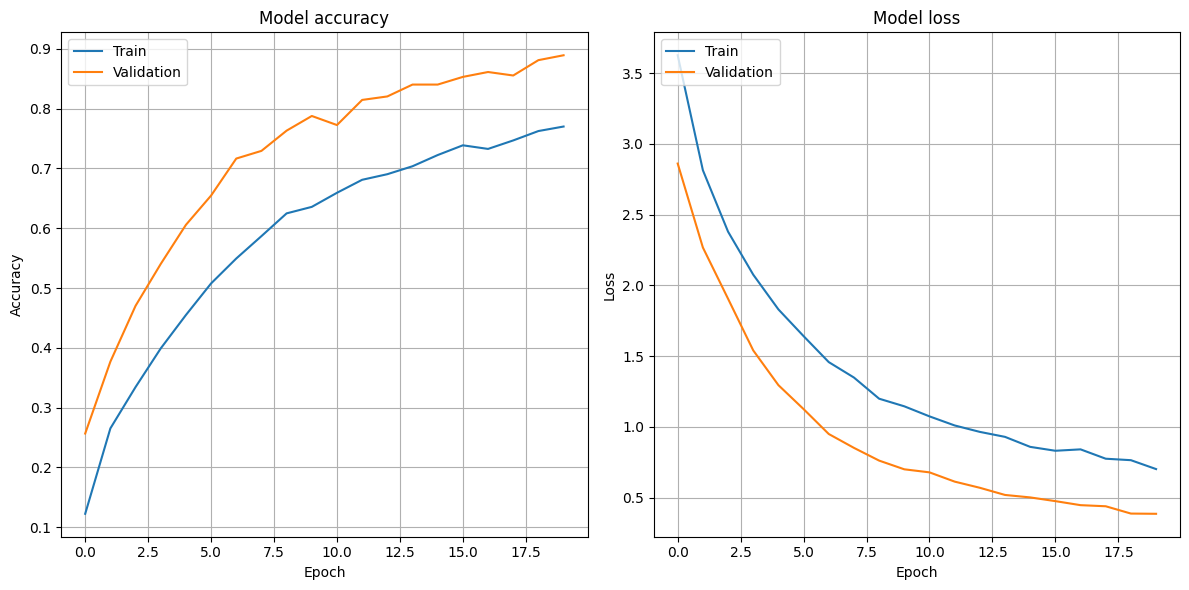

In [41]:
# Plot training history
plt.figure(figsize=(12,6))

# Plot training and validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training and validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
# save the entire model in HDF5 format
model.save('model.h5')   